# Testing the Linear Model trained in TensorFlow 

In [2]:
from __future__ import print_function
from link_bot_notebooks import notebook_finder
from link_bot_notebooks import toy_problem_optimization_common as tpo
from math import acos
import numpy as np
import matplotlib.pyplot as plt
from link_bot_notebooks.linear_tf_model import LinearTFModel

importing Jupyter notebook from /home/pmitrano/catkin_ws/src/link_bot/link_bot_notebooks/src/link_bot_notebooks/toy_problem_optimization_common.ipynb


In [6]:
goal = np.array([[0], [0], [1], [0], [2], [0]])
args = {'checkpoint': "log_data/10_step/December_02_20:11:23__2d7f58a3ec/nn.ckpt-50000", 'log': False}
dataset = "../../../link_bot_teleop/data/2_link_pos_and_vel_2.txt"
n, x = tpo.load_train(dataset, N=6, L=2, extract_func=tpo.link_pos_vel_extractor2(6))
model = LinearTFModel(args, N=6, M=2, L=2, n_steps=1)
model.load()

INFO:tensorflow:Restoring parameters from log_data/10_step/December_02_20:11:23__2d7f58a3ec/nn.ckpt-50000
Restored ckpt log_data/10_step/December_02_20:11:23__2d7f58a3ec/nn.ckpt-50000 at step 50000


In [8]:
A, B, C, D, c_loss, sp_loss, cp_loss, reg, loss = model.evaluate(x, goal, display=True)

Cost Loss: 0.155440941453
State Prediction Loss: 12.3495721817
Cost Prediction Loss: 1.33972334862
Regularization: 4.05006410631e-08
Overall Loss: 13.8447370529
A:
[[ 1.18  0.69  0.17  0.07  0.02  0.03]
 [ 0.51 -1.14  0.18 -0.   -0.07 -0.07]]
B:
[[-0.   -0.03]
 [ 0.18 -2.01]]
C:
[[ 0.05  0.01]
 [-0.26 -0.05]]
D:
[[ 0.42 -0.11]
 [ 0.15  0.5 ]]


In [10]:
data = tpo.load_data(dataset, g=goal, extract_func=tpo.two_link_pos_vel_extractor)

In [ ]:
# tpo.plot_costmap(plt, model, data, goal, samples=100, spread=0.4)
min_sample, min_cost = tpo.plot_costmap(plt, model, data, goal, samples=10, spread=2)
print("min cost", min_cost)
plt.scatter([min_sample[0]], [min_sample[1]], s=100, c='Red', label='min sample');
plt.scatter(goal[0], goal[1], s=100, c='Green', label='goal');

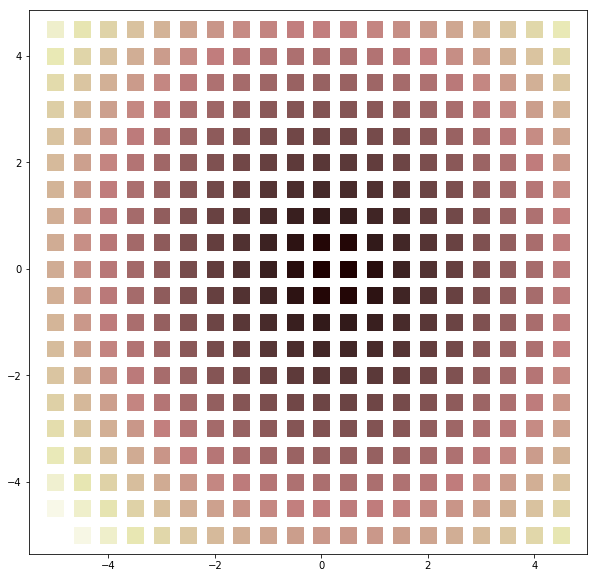

In [11]:
tpo.plot_costmap_2(plt, model, data, goal, resolution=.5, minimum=-5, maximum=5);

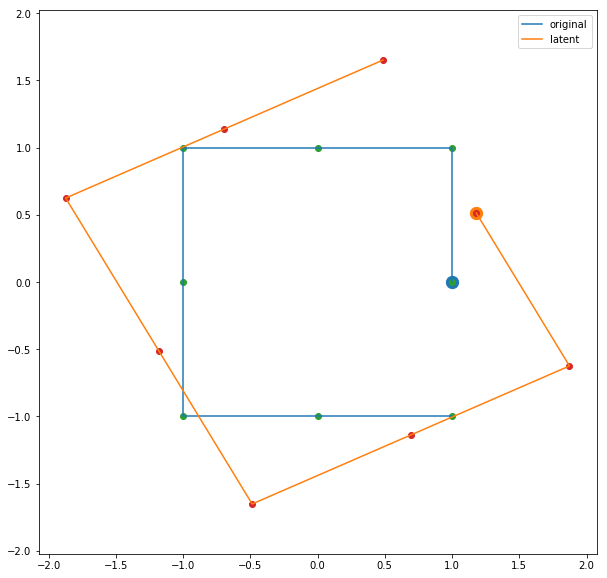

In [12]:
points = np.array([[1,0], [1,1], [0,1], [-1,1], [-1,0], [-1,-1], [0,-1], [1,-1]])
R = model.get_A()[:,:2]
new_points = []
for p in points:
    new_p = np.dot(R, p)
    new_points.append(new_p)
new_points = np.array(new_points)
    
plt.figure(figsize=(10,10))
plt.scatter([points[0,0]], [points[0,1]], s=150)
plt.scatter([new_points[0,0]], [new_points[0,1]], s=150)
plt.scatter([p[0] for p in points], [p[1] for p in points])
plt.scatter([p[0] for p in new_points], [p[1] for p in new_points])
plt.plot([p[0] for p in points], [p[1] for p in points], label='original')
plt.plot([p[0] for p in new_points], [p[1] for p in new_points], label='latent')
plt.legend()
plt.axis("equal");

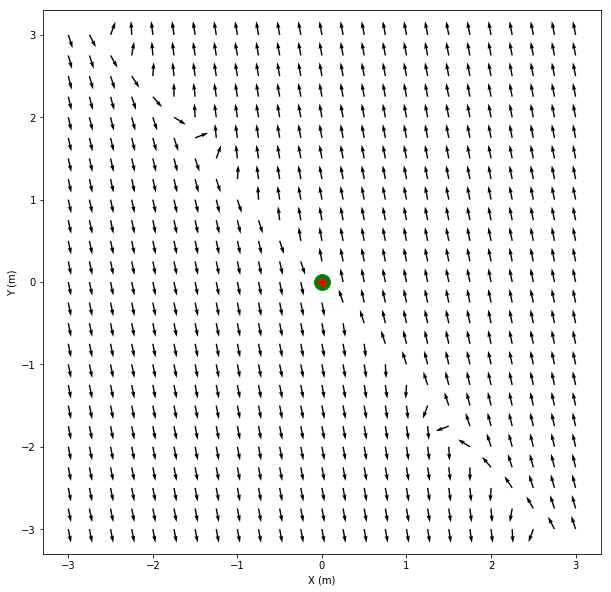

In [15]:
r = 0.25
cx = 0
cy = 0
m = 3
x = []
y = []
u = []
v = []
goal = np.array([[cx], [cy], [0], [0], [0], [0]])
min_a = 1e9 * np.ones((2, 1))
min_a_x = None
min_a_y = None
MAX_SPEED=1
og = model.reduce(goal)
for s1 in np.arange(cx-m, cx+m+r, r):
    for s2 in np.arange(cy-m, cy+m+r, r):
        o = model.reduce(np.array([[s1], [s2], [0], [0], [0], [0]]))
        o1 = o[0, 0]
        o2 = o[1, 0]
        full_a, full_c, next_o = model.act(o, goal)
        if np.linalg.norm(full_a) > MAX_SPEED:
            a = full_a / np.linalg.norm(full_a) * MAX_SPEED  # a is in meters per second. Cap to 0.75
        else:
            a = full_a

        x.append(s1)
        y.append(s2)
        u.append(a[0, 0, 0])
        v.append(a[0, 1, 0])
        if np.linalg.norm(full_a) < np.linalg.norm(min_a):
            min_a = a
            min_a_x = s1
            min_a_y = s2
        
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.scatter(goal[0, 0], goal[1, 0], s=250, c='g')
ax.scatter(min_a_x, min_a_y, s=50, c='r')
q = ax.quiver(x, y, u, v, scale=40, width=0.0025)
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)");